## 导入库和设置种子
导入必要的库和模块，如 numpy, torch, torchvision, matplotlib, sklearn 等。
定义一个 same_seeds 函数来设置随机种子，以确保结果可重现。
调用 same_seeds 函数，将种子设置为 112345。

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
import seaborn as sns
import random
import os

# 设置随机种子以确保可重现性
def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(112345)


## 下载和准备数据
下载并标准化 MNIST 数据集，将数据转换为张量格式。
将数据分为正常数据（标签为 0-4）和异常数据（标签为 5-9）。
创建训练集 train_data 和测试集 test_data。

In [4]:
# 下载MNIST数据集并进行标准化
transform = transforms.Compose([
    transforms.ToTensor(),
])

mnist_train = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# 将正常数据（0-4）和异常数据（5-9）分开
normal_train_data = [(x, 0) for x, y in mnist_train if y < 5]
anomaly_train_data = [(x, 1) for x, y in mnist_train if y >= 5]
normal_test_data = [(x, 0) for x, y in mnist_test if y < 5]
anomaly_test_data = [(x, 1) for x, y in mnist_test if y >= 5]

# 创建训练集和测试集
train_data = normal_train_data
test_data = normal_test_data + anomaly_test_data


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 48639078.18it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1699959.22it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13287040.70it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2910699.58it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## 创建数据加载器
定义 collate_fn 函数以正确打包批处理数据。
使用 DataLoader 为训练数据和测试数据创建加载器。
打印一些样本数据以确认数据加载正常。

In [5]:
# 创建数据加载器
def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack([img for img in images], dim=0)
    labels = torch.tensor(labels, dtype=torch.int64)
    return images, labels

train_loader = DataLoader(train_data, batch_size=128, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False, collate_fn=collate_fn)

# 打印一些样本数据以确认数据加载正常
for images, labels in train_loader:
    print(f'Initial batch shape: {images.shape}, {labels.shape}')
    print(f'Sample data: {images[0]}, Label: {labels[0]}')
    break


Initial batch shape: torch.Size([128, 1, 28, 28]), torch.Size([128])
Sample data: tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

## 定义自编码器模型
# 全连接自编码器（FCN）
定义一个全连接自编码器模型。
编码器部分由四层全连接层组成，每层之间使用 ReLU 激活函数。
解码器部分将编码器的输出转换回原始输入的形状。
使用 Sigmoid 激活函数将输出压缩到 [0, 1] 范围。

# 卷积自编码器（CNN）
定义一个卷积自编码器模型。
编码器部分由三层卷积层组成，每层之间使用 ReLU 激活函数。
解码器部分使用卷积转置层将特征图恢复到原始输入的形状。
使用 Sigmoid 激活函数将输出压缩到 [0, 1] 范围。
在前向传递中打印编码和解码后的张量形状。

# 变分自编码器（VAE）
定义一个变分自编码器模型。
编码器部分由三层卷积层和一个全连接层组成，每层之间使用 ReLU 激活函数。
编码器输出均值和对数方差，并通过 reparametrize 方法生成潜在变量。
解码器部分使用卷积转置层将潜在变量恢复到原始输入的形状。
使用 Sigmoid 激活函数将输出压缩到 [0, 1] 范围。
在编码和解码过程中打印中间张量的形状。

# ResNet自编码器
定义一个基于 ResNet 的自编码器模型。
编码器部分使用多个卷积层、批归一化和池化层。
解码器部分使用卷积转置层和批归一化，将特征图恢复到原始输入的形状。
使用 Sigmoid 激活函数将输出压缩到 [0, 1] 范围。
在前向传递中打印编码和解码后的张量形状。

In [6]:
# 定义全连接自编码器（FCN）
class FCNAutoencoder(nn.Module):
    def __init__(self):
        super(FCNAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 3))

        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid())  # 使用 Sigmoid 激活函数将输出压缩到 [0, 1] 范围

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
# 定义卷积自编码器（CNN）
class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=1, padding=1, output_padding=0),
            nn.Upsample(size=(28, 28)),  # 使用上采样确保输出尺寸为 28x28
            nn.Sigmoid())  # 使用 Sigmoid 激活函数将输出压缩到 [0, 1] 范围

    def forward(self, x):
        x = self.encoder(x)
        print(f'Encoded shape: {x.shape}')
        x = self.decoder(x)
        print(f'Decoded shape: {x.shape}')
        return x
# 定义变分自编码器（VAE）
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.fc1 = nn.Linear(64 * 4 * 4, 128)  # 调整此处以匹配编码后的形状
        self.fc2_mu = nn.Linear(128, 20)
        self.fc2_logvar = nn.Linear(128, 20)
        self.fc3 = nn.Linear(20, 64 * 4 * 4)  # 调整此处以匹配解码前的形状
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=1, padding=1, output_padding=0),
            nn.Upsample(size=(28, 28)),  # 使用上采样确保输出尺寸为 28x28
            nn.Sigmoid())  # 使用 Sigmoid 激活函数将输出压缩到 [0, 1] 范围

    def encode(self, x):
        h1 = self.encoder(x)
        print(f'After encoder conv layers: {h1.shape}')
        h1 = h1.view(-1, 64 * 4 * 4)  # 确保形状匹配
        print(f'After view: {h1.shape}')
        h2 = self.fc1(h1)
        print(f'After fc1: {h2.shape}')
        return self.fc2_mu(h2), self.fc2_logvar(h2)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = self.fc3(z)
        print(f'After fc3: {h3.shape}')
        h3 = h3.view(-1, 64, 4, 4)  # 确保形状匹配
        print(f'After view: {h3.shape}')
        return self.decoder(h3)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar
# 定义ResNet模型
class ResNetAutoencoder(nn.Module):
    def __init__(self):
        super(ResNetAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Upsample(size=(28, 28)),  # 使用上采样确保输出尺寸为 28x28
            nn.Sigmoid())  # 使用 Sigmoid 激活函数将输出压缩到 [0, 1] 范围

    def forward(self, x):
        x = self.encoder(x)
        print(f'Encoded shape: {x.shape}')
        x = self.decoder(x)
        print(f'Decoded shape: {x.shape}')
        return x


## 训练模型函数
定义一个通用的训练函数 train_model。
使用 DataLoader 提供的训练数据进行训练。
根据 model_type 处理输入的形状。
检查输入是否包含 NaN 值。
打印当前批次的输入形状。
前向传递计算输出。
根据模型类型（普通自编码器或变分自编码器）计算损失。
反向传播更新模型参数。
记录并打印每个 epoch 的平均损失。
保存损失最小的模型。

In [7]:
# 训练模型函数
def train_model(model, train_loader, criterion, optimizer, model_type, num_epochs=20):
    best_loss = float('inf')
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs, _ = data
            inputs = inputs.view(inputs.size(0), -1) if model_type == 'fcn' else inputs

            # 检查输入是否存在问题
            if torch.any(torch.isnan(inputs)):
                print(f"NaN found in inputs at epoch {epoch+1}, batch {i+1}")
                continue

            print(f"Epoch {epoch+1}, Batch {i+1}, Input Shape: {inputs.shape}")
            optimizer.zero_grad()
            outputs = model(inputs)

            # 检查输出是否存在问题
            if model_type == 'vae':
                reconstructed, mu, logvar = outputs
                if torch.any(torch.isnan(reconstructed)) or torch.any(torch.isnan(mu)) or torch.any(torch.isnan(logvar)):
                    print(f"NaN found in outputs at epoch {epoch+1}, batch {i+1}")
                    continue
                loss = criterion(reconstructed, inputs, mu, logvar)
            else:
                if torch.any(torch.isnan(outputs)):
                    print(f"NaN found in outputs at epoch {epoch+1}, batch {i+1}")
                    continue
                loss = criterion(outputs, inputs)

            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), f'best_model_{model_type}.pth')


## 定义损失函数和优化器
定义 vae_loss 用于变分自编码器的训练损失函数，包括重构误差（BCE）和 Kullback-Leibler 散度（KLD）。
定义 vae_test_loss 用于变分自编码器的测试损失函数，使用 MSE。
定义 mse_loss 用于普通自编码器的损失函数，支持 none 和 sum 两种 reduction 方式

In [8]:
# 定义损失函数和优化器
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def vae_test_loss(recon_x, x):
    return nn.functional.mse_loss(recon_x, x, reduction='none')

def mse_loss(recon_x, x, reduction='mean'):
    if reduction == 'none':
        return nn.functional.mse_loss(recon_x, x, reduction='none')
    elif reduction == 'sum':
        return nn.functional.mse_loss(recon_x, x, reduction='sum')
    else:
        return nn.functional.mse_loss(recon_x, x)


## 训练各个模型
创建一个字典 model_classes，包含四种自编码器模型。
逐个模型进行训练。
根据模型类型选择合适的损失函数。
使用 Adam 优化器进行训练。

In [9]:
# 训练各个模型
model_classes = {
    'fcn': FCNAutoencoder(),
    'cnn': CNNAutoencoder(),
    'vae': VAE(),
    'resnet': ResNetAutoencoder()
}

# 在 CPU 上训练
for model_type in model_classes.keys():
    print(f'Training {model_type} model...')
    model = model_classes[model_type]
    criterion = vae_loss if model_type == 'vae' else mse_loss
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    train_model(model, train_loader, criterion, optimizer, model_type)


流式输出内容被截断，只能显示最后 5000 行内容。
Decoded shape: torch.Size([128, 1, 28, 28])
Epoch 14, Batch 17, Input Shape: torch.Size([128, 1, 28, 28])
Encoded shape: torch.Size([128, 128, 2, 2])
Decoded shape: torch.Size([128, 1, 28, 28])
Epoch 14, Batch 18, Input Shape: torch.Size([128, 1, 28, 28])
Encoded shape: torch.Size([128, 128, 2, 2])
Decoded shape: torch.Size([128, 1, 28, 28])
Epoch 14, Batch 19, Input Shape: torch.Size([128, 1, 28, 28])
Encoded shape: torch.Size([128, 128, 2, 2])
Decoded shape: torch.Size([128, 1, 28, 28])
Epoch 14, Batch 20, Input Shape: torch.Size([128, 1, 28, 28])
Encoded shape: torch.Size([128, 128, 2, 2])
Decoded shape: torch.Size([128, 1, 28, 28])
Epoch 14, Batch 21, Input Shape: torch.Size([128, 1, 28, 28])
Encoded shape: torch.Size([128, 128, 2, 2])
Decoded shape: torch.Size([128, 1, 28, 28])
Epoch 14, Batch 22, Input Shape: torch.Size([128, 1, 28, 28])
Encoded shape: torch.Size([128, 128, 2, 2])
Decoded shape: torch.Size([128, 1, 28, 28])
Epoch 14, Batch 23, Input Sha

## 测试模型函数
定义一个通用的测试函数 test_model。
使用 DataLoader 提供的测试数据进行评估。
根据 model_type 处理输入的形状。
前向传递计算输出。
根据模型类型（普通自编码器或变分自编码器）计算损失。
记录每个样本的损失和标签。
返回所有样本的损失和标签。

In [10]:
# 测试模型函数
def test_model(model, test_loader, criterion, model_type):
    model.eval()
    errors = []
    labels = []
    with torch.no_grad():
        for data in test_loader:
            inputs, targets = data
            inputs = inputs.view(inputs.size(0), -1) if model_type == 'fcn' else inputs
            outputs = model(inputs)
            if model_type == 'vae':
                outputs, _, _ = outputs
                loss = vae_test_loss(outputs, inputs)
            else:
                loss = criterion(outputs, inputs, reduction='none')
            errors.append(loss.view(loss.size(0), -1).sum(dim=1).cpu().numpy())
            labels.append(targets.numpy())
    errors = np.concatenate(errors)
    labels = np.concatenate(labels)
    return errors, labels


## 测试各个模型
逐个模型进行测试。
加载每个模型的最优状态。
根据模型类型选择合适的损失函数。
调用 test_model 进行测试并记录结果。

In [11]:
# 测试各个模型
results = {}
for model_type in model_classes.keys():
    print(f'Testing {model_type} model...')
    model = model_classes[model_type]
    model.load_state_dict(torch.load(f'best_model_{model_type}.pth'))
    criterion = vae_loss if model_type == 'vae' else mse_loss
    errors, labels = test_model(model, test_loader, criterion, model_type)
    results[model_type] = (errors, labels)


Testing fcn model...
Testing cnn model...
Encoded shape: torch.Size([128, 64, 4, 4])
Decoded shape: torch.Size([128, 1, 28, 28])
Encoded shape: torch.Size([128, 64, 4, 4])
Decoded shape: torch.Size([128, 1, 28, 28])
Encoded shape: torch.Size([128, 64, 4, 4])
Decoded shape: torch.Size([128, 1, 28, 28])
Encoded shape: torch.Size([128, 64, 4, 4])
Decoded shape: torch.Size([128, 1, 28, 28])
Encoded shape: torch.Size([128, 64, 4, 4])
Decoded shape: torch.Size([128, 1, 28, 28])
Encoded shape: torch.Size([128, 64, 4, 4])
Decoded shape: torch.Size([128, 1, 28, 28])
Encoded shape: torch.Size([128, 64, 4, 4])
Decoded shape: torch.Size([128, 1, 28, 28])
Encoded shape: torch.Size([128, 64, 4, 4])
Decoded shape: torch.Size([128, 1, 28, 28])
Encoded shape: torch.Size([128, 64, 4, 4])
Decoded shape: torch.Size([128, 1, 28, 28])
Encoded shape: torch.Size([128, 64, 4, 4])
Decoded shape: torch.Size([128, 1, 28, 28])
Encoded shape: torch.Size([128, 64, 4, 4])
Decoded shape: torch.Size([128, 1, 28, 28])
E

## 可视化结果
逐个模型进行结果的可视化。
使用 roc_curve 和 auc 计算 ROC 曲线和 AUC。
绘制 ROC 曲线并显示。

# 什么是 ROC 曲线
ROC 曲线（Receiver Operating Characteristic Curve，受试者工作特性曲线）是用来评估分类模型性能的一种图形工具。它展示了分类模型在不同阈值下的表现，通过绘制 真阳性率（True Positive Rate, TPR） 对 假阳性率（False Positive Rate, FPR） 的曲线来实现。

真阳性率（TPR）：也称为召回率或灵敏度，表示所有实际正样本中被正确预测为正样本的比例。

假阳性率（FPR）：表示所有实际负样本中被错误预测为正样本的比例。

# 什么是 AUC

AUC（Area Under the Curve，曲线下面积）是 ROC 曲线下方的面积，它是对分类器性能的一个综合度量。AUC 值介于 0 和 1 之间，越接近 1 表示分类器性能越好。

AUC = 1：完美的分类器，能够在任何阈值下都能完美地区分正负样本。

AUC = 0.5：表现最差的分类器，无法区分正负样本，与随机猜测相同。

0.5 < AUC < 1：分类器的性能在随机猜测和完美分类器之间。

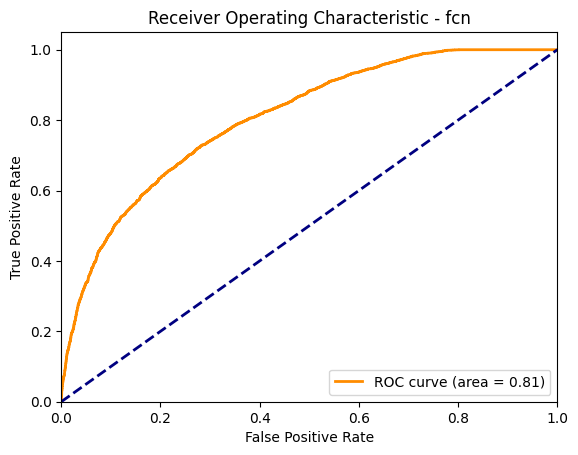

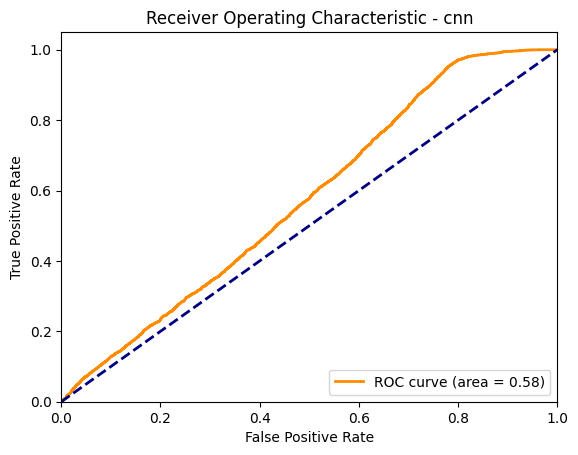

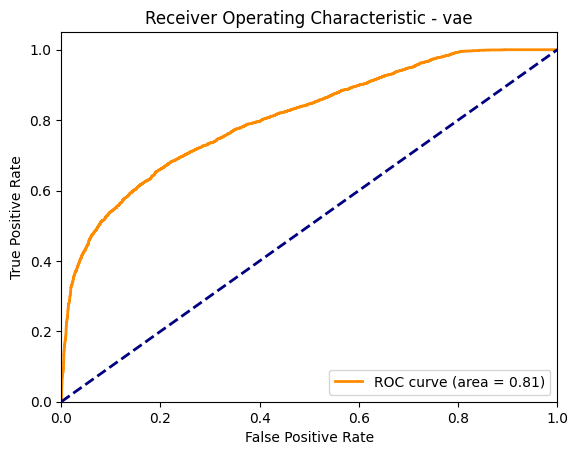

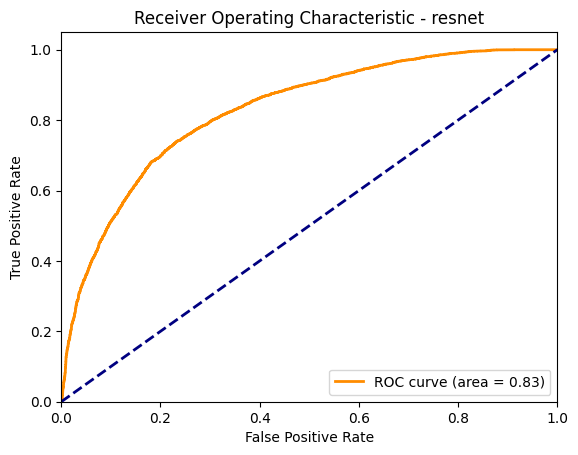

In [12]:
# 可视化结果
for model_type, (errors, labels) in results.items():
    fpr, tpr, thresholds = roc_curve(labels, errors)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_type}')
    plt.legend(loc="lower right")
    plt.show()


## 加载已保存的模型
解释：

加载已保存的 FCN 模型的最优状态。
将模型设置为评估模式。
可以进一步进行推理或继续训练。

In [13]:
# 加载已保存的模型
model_type = 'fcn'
model = FCNAutoencoder()
model.load_state_dict(torch.load(f'best_model_{model_type}.pth'))

# 使用加载的模型进行推理或继续训练
model.eval()
# ... (进行推理或继续训练)


FCNAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)